# HA3 "Recommender System" take 08

## Setup

In [1]:
import numpy as np
import pandas as pd

from random import randrange

import matplotlib.pyplot as plt

## Load Data

In [2]:
file_path = "../../data/assignment_03/"

baskets_pq = "baskets.parquet"
coupons_pq = "coupons.parquet"
prediction_index_pq = "prediction_index.parquet"

b_df = pd.read_parquet(file_path + baskets_pq)
c_df = pd.read_parquet(file_path + coupons_pq)
pi_df = pd.read_parquet(file_path + prediction_index_pq)

print(f"baskets_df: {b_df.shape}")
print(f"coupons_df: {c_df.shape}")
print(f"prediction_index_df: {pi_df.shape}")

baskets_df: (68841598, 4)
coupons_df: (45000000, 4)
prediction_index_df: (500000, 3)


## Data Preprocessing

### A. Shoppers Targetting

In [3]:
num_of_shoppers = 500

shoppers = [randrange(0, 2000) for i in range(num_of_shoppers)]
# shoppers = [i for i in range(num_of_shoppers)]
# shoppers

### B. Original Prices

In [4]:
orig_price = b_df.groupby(["product"])["price"].agg(["max"]).reset_index()
print(f"orig_price.shape: {orig_price.shape}")
orig_price.head(2)

orig_price.shape: (250, 2)


,product,max
0,0,688
1,1,560


### C. Generate master dataframe with selected shoppers

In [5]:
def gen_complete_week_prod_df_for_shoppers(list_shoppers, orig_df):
    products = np.array([p for p in range(250)])
    orig_price_list = orig_df["max"].values
    
    weeks = [i for i in range(90)]
    
    product_price_pair = np.stack((products, orig_price_list), axis=0).T
    
    prod_in_weeks = []
    for w in weeks:
        for p in product_price_pair:
            prod_in_weeks.append([w, *p])
    
    df_template = pd.DataFrame(data=prod_in_weeks, columns=["week", "product", "orig_price"])
    
    df_master = None;
    
    for idx, shoppers in enumerate(list_shoppers):

        df_local = df_template.copy()
        df_local["shopper"] = shoppers
        
        if idx == 0:
            df_master = df_local
        else:
            # stack it
            df_master = pd.concat([df_master, df_local], axis=0)
    return df_master

In [6]:
df = gen_complete_week_prod_df_for_shoppers(shoppers, orig_price)
print(f"df.shape: {df.shape}")
df.head(3)

df.shape: (11250000, 4)


,week,product,orig_price,shopper
0,0,0,688,1045
1,0,1,560,1045
2,0,2,773,1045


### D. Target Column added

In [7]:
b_df["target"] = 1
df = pd.merge(df, b_df, how="left", on=["week", "shopper", "product"])
df["target"] = df["target"].fillna(0)
print(f"df.shape: {df.shape}")
df.head(3)

df.shape: (11250000, 6)


,week,product,orig_price,shopper,price,target
0,0,0,688,1045,NaN,0.0
1,0,1,560,1045,560.0,1.0
2,0,2,773,1045,NaN,0.0


### E. Discount Given Column added

In [8]:
c_df["coupon_given"] = 1
df = df.merge(right=c_df, how="left", on=["week", "shopper", "product"])
df["discount"] = df["discount"].fillna(0)
df["coupon_given"] = df["coupon_given"].fillna(0)
print(f"df.shape: {df.shape}")
df.head(3)

df.shape: (11250000, 8)


,week,product,orig_price,shopper,price,target,discount,coupon_given
0,0,0,688,1045,NaN,0.0,0.0,0.0
1,0,1,560,1045,560.0,1.0,0.0,0.0
2,0,2,773,1045,NaN,0.0,0.0,0.0


### F. Price with discount

In [9]:
df["price_w_discount"] = df["orig_price"] - df["discount"]
df.head(3)

,week,product,orig_price,shopper,price,target,discount,coupon_given,price_w_discount
0,0,0,688,1045,NaN,0.0,0.0,0.0,688.0
1,0,1,560,1045,560.0,1.0,0.0,0.0,560.0
2,0,2,773,1045,NaN,0.0,0.0,0.0,773.0


In [10]:
# price column is no longer necessary so removing it
df = df.drop(columns=["price"])
df.head(3)

,week,product,orig_price,shopper,target,discount,coupon_given,price_w_discount
0,0,0,688,1045,0.0,0.0,0.0,688.0
1,0,1,560,1045,1.0,0.0,0.0,560.0
2,0,2,773,1045,0.0,0.0,0.0,773.0


## Split Data Before Feature Engineering

In [11]:
# Train: 0 - 88
# Test: 88 - 89
cut_day = 89

# Separate train and test
train = df[df["week"] < cut_day]
test = df[df["week"] >= cut_day]

b_train = b_df[b_df["week"] < cut_day]
b_test = b_df[b_df["week"] >= cut_day]

c_train = c_df[c_df["week"] < cut_day]
c_test = c_df[c_df["week"] >= cut_day]

print(f"Master: {df.shape}, Train: {train.shape}, Test: {test.shape}")

Master: (11250000, 8), Train: (11125000, 8), Test: (125000, 8)


## Feature Engineering

### A. Average Bakset Size per Shopper per week - Shopper's Perspective

In [12]:
num_prod_per_week_per_shopper = b_train.groupby(["shopper", "week"], as_index=False)["product"].count()
num_prod_per_week_per_shopper = num_prod_per_week_per_shopper.rename({"product": "avg_basket_size"}, axis=1)
avg_baskets = num_prod_per_week_per_shopper.groupby(["shopper"], as_index=False)["avg_basket_size"].mean()

In [13]:
# Merge to shoppers on train and test

train = train.merge(avg_baskets, how="left", on="shopper")
test = test.merge(avg_baskets, how="left", on="shopper")

In [14]:
train.head(2)

,week,product,orig_price,shopper,target,discount,coupon_given,price_w_discount,avg_basket_size
0,0,0,688,1045,0.0,0.0,0.0,688.0,8.674157
1,0,1,560,1045,1.0,0.0,0.0,560.0,8.674157


### B. Average Price per Shopper per Week - Shopper's Perspective

- How much on average did a shopper spend a week?

In [15]:
avg_price_per_shopper_per_week = b_train.groupby(["shopper"], as_index=False)["price"].mean()

In [16]:
# Include it to the shoppers

train = train.merge(avg_price_per_shopper_per_week, how="left", on="shopper")
test = test.merge(avg_price_per_shopper_per_week, how="left", on="shopper")

In [17]:
train.head(2)

,week,product,orig_price,shopper,target,discount,coupon_given,price_w_discount,avg_basket_size,price
0,0,0,688,1045,0.0,0.0,0.0,688.0,8.674157,592.661917
1,0,1,560,1045,1.0,0.0,0.0,560.0,8.674157,592.661917


### C. Number of Unique Products purchased per Shopper - Shopper's Perspective

In [18]:
num_unique_prods_per_shopper = b_train.groupby(["shopper"], as_index=False)["product"].nunique()
num_unique_prods_per_shopper = num_unique_prods_per_shopper.rename({ "product": "num_unique_prods"}, axis=1)

In [19]:
# Include it to the shoppers

train = train.merge(num_unique_prods_per_shopper, how="left", on="shopper")
test = test.merge(num_unique_prods_per_shopper, how="left", on="shopper")

### D. Number of times products have been reordered - Product's perspective on Shoppers

In [20]:
# copy product column
num_reordered = b_train.copy()
num_reordered["num_reordered"] = num_reordered["product"]
num_reordered = num_reordered.groupby(["shopper", "product", "num_reordered"], as_index=False)["num_reordered"].count()
# num_reordered

In [21]:
# Merge to train and test
train = train.merge(num_reordered, how="left", on=["shopper","product"])
test = test.merge(num_reordered, how="left", on=["shopper","product"])

In [22]:
train["num_reordered"] = train["num_reordered"].fillna(0)
test["num_reordered"] = test["num_reordered"].fillna(0)

### E. Weeks Since Prior Order

#### a. train

In [23]:
# Train set
addkey = train.groupby(['shopper','product'])["target"].apply(lambda x : x.eq(1).shift().fillna(0).cumsum())
train['weeks_since_prior_order'] = train["target"].eq(0).groupby([train['shopper'], train['product'], addkey]).cumcount().add(1) # .cumsum()

In [24]:
train.sample(5)

,week,product,orig_price,shopper,target,discount,coupon_given,price_w_discount,avg_basket_size,price,num_unique_prods,num_reordered,weeks_since_prior_order
10226674,55,174,753,1707,0.0,0.0,0.0,753.0,7.044944,601.912281,56,0.0,56
2292343,2,93,577,303,0.0,0.0,0.0,577.0,7.258427,574.871517,70,0.0,3
7273816,81,66,743,83,0.0,0.0,0.0,743.0,6.955056,588.525040,69,0.0,82
4253769,16,19,744,1670,0.0,0.0,0.0,744.0,9.101124,591.307407,90,0.0,17
3154195,67,195,612,1211,0.0,0.0,0.0,612.0,8.741573,564.372751,75,0.0,68


#### b. test

In [25]:
# Test set
last_weeks_since_prior_order = train.groupby(['shopper', 'product']).weeks_since_prior_order.last() + 1

In [26]:
test = test.merge(last_weeks_since_prior_order, on=['shopper', 'product'])

### F. Category

#### f - 1. gensim Word2Vec

In [27]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [28]:
# Caution ! Takes REAALLY Long !!
# TEMPORARY - Since target shopper is limited to 2000, reduce the basket to 2000

# by basket => groupby(["week", "shopper"])

num_shoppers = 5000

by_basket_str = b_df[b_df["shopper"] < num_shoppers]
by_basket_str["product"] = by_basket_str["product"].astype(str)
by_basket_str = by_basket_str.groupby(["week", "shopper"])["product"].apply(list).reset_index(name="list_prod")

<ipython-input-28-b470deef2cb6>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  by_basket_str["product"] = by_basket_str["product"].astype(str)


In [29]:
by_basket_str.head()

,week,shopper,list_prod
0,0,0,"[71, 91, 116, 123, 157, 167, 171, 184, 207, 225]"
1,0,1,"[22, 35, 92, 146, 168, 200, 211, 229]"
2,0,2,"[14, 121, 164, 218, 230, 249]"
3,0,3,"[6, 67, 98, 137, 145, 192, 222]"
4,0,4,"[25, 76, 156, 188, 234]"


In [30]:
by_basket = by_basket_str["list_prod"].tolist()

In [31]:
# Create a Word2Vec model
w2v_model = Word2Vec(
    sentences=by_basket,
    min_count=10,
    negative=5,
    sample=0,
    sg=1,
    workers=10,
)

# summarize the loaded model
print(w2v_model)

Word2Vec(vocab=250, size=100, alpha=0.025)


In [32]:
# Summarize vocabulary
words = list(w2v_model.wv.vocab)
print("Words Length: {}".format(len(words)))
print(words[0:10])

Words Length: 250
['71', '91', '116', '123', '157', '167', '171', '184', '207', '225']


In [33]:
# Product vector for 76

# Most similar to a sample product 76
print(w2v_model.wv.most_similar(positive='76'))
print(f"Product Vector size: {len(w2v_model['76'])}")
print(w2v_model["76"])

[('74', 0.677214503288269), ('71', 0.6661261320114136), ('79', 0.6327258944511414), ('72', 0.6240032315254211), ('73', 0.6211162209510803), ('78', 0.6182807087898254), ('75', 0.6175341010093689), ('77', 0.5969045162200928), ('70', 0.4974876642227173), ('4', 0.2897788882255554)]
Product Vector size: 100
[-0.6378399  -0.39120352 -0.02826649 -0.09698865  0.66375476 -0.20122798
 -0.16417977 -0.19422676 -0.25085306 -0.40593758  0.22815895  0.09401505
  0.54107195 -0.07544153  0.05723818  0.0900609   0.09058281  0.17793836
  0.21234316 -0.21157861  0.04928506  0.2542332   0.03635726 -0.15064329
 -0.52069795 -0.18990704  0.39039254  0.23324229  0.0700544  -0.04839453
 -0.3209386   0.20548636  0.40738517  0.29243675  0.21299246 -0.3514389
  0.26533756 -0.06253164  0.26599464 -0.32281858 -0.30075473  0.31016797
  0.40111184  0.17581885 -0.49585152 -0.18163168  0.31218192 -0.46623442
  0.37764162  0.11582473  0.16027735  0.02415344  0.0163057   0.19880499
  0.15514581 -0.0748875   0.35989115 -0.

<ipython-input-33-aff2342eceae>:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  print(f"Product Vector size: {len(w2v_model['76'])}")
<ipython-input-33-aff2342eceae>:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  print(w2v_model["76"])


#### f - 2. t-SNE

In [34]:
X = w2v_model[w2v_model.wv.vocab]
print(X.shape)
X

(250, 100)


<ipython-input-34-a34c8899bf7e>:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  X = w2v_model[w2v_model.wv.vocab]


array([[-0.2895839 ,  0.04778377,  0.02249708, ..., -0.41088125,
        -0.54661113, -0.31075528],
       [ 0.499356  , -0.21183808,  0.08556315, ...,  0.28100145,
        -0.34660417, -0.6225884 ],
       [-0.21617395,  0.6078007 ,  0.12517339, ...,  0.70284903,
        -0.20511957, -0.28097484],
       ...,
       [-0.01832466, -0.00308146, -0.02200852, ...,  0.28290263,
         0.03835472, -0.6984836 ],
       [-0.61663824, -0.10761869,  0.2638543 , ...,  0.6448534 ,
        -0.07382338, -0.17086223],
       [-0.03675385,  0.22312428, -0.5442481 , ..., -0.09040421,
        -0.583199  , -0.07797411]], dtype=float32)

In [35]:
N = 1000

config_tsne = {
    "n_components": 2,
    "init": "pca",
    "random_state": 0,
    "n_iter": 1_000,
}

In [36]:
tsne = TSNE(**config_tsne)
Y_tsne = tsne.fit_transform(X)

In [37]:
Y_tsne[0:10]

array([[ -9.89249   ,   6.7734365 ],
       [  0.650369  ,  11.7110405 ],
       [  1.805379  ,  -1.1099257 ],
       [  4.9111075 ,   7.4191046 ],
       [ -2.4500258 ,  -2.8079405 ],
       [ -3.5514762 ,   8.847015  ],
       [ -4.4328866 ,   3.9797938 ],
       [ -6.2253733 ,  -0.67359877],
       [  5.3175526 ,   3.1513443 ],
       [-11.753261  ,   1.5194231 ]], dtype=float32)

In [38]:
# kl_divergence - What does this indicate ?
tsne.kl_divergence_

0.42372632026672363

In [39]:
# Learning rate
tsne.learning_rate

200.0

In [40]:
# Method
tsne.method

'barnes_hut'

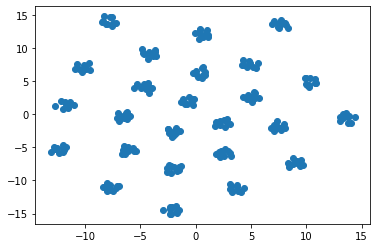

In [41]:
# We see 25 clusters
plt.scatter(Y_tsne[:, 0], Y_tsne[:, 1], cmap=plt.cm.Spectral)
plt.show()

In [42]:
# kMeans
from sklearn.cluster import KMeans

In [43]:
Y_tsne[0:10]

array([[ -9.89249   ,   6.7734365 ],
       [  0.650369  ,  11.7110405 ],
       [  1.805379  ,  -1.1099257 ],
       [  4.9111075 ,   7.4191046 ],
       [ -2.4500258 ,  -2.8079405 ],
       [ -3.5514762 ,   8.847015  ],
       [ -4.4328866 ,   3.9797938 ],
       [ -6.2253733 ,  -0.67359877],
       [  5.3175526 ,   3.1513443 ],
       [-11.753261  ,   1.5194231 ]], dtype=float32)

In [44]:
kmeans = KMeans(n_clusters=25, random_state=0).fit(Y_tsne)
kmeans.labels_

array([ 9,  4, 18, 21, 24, 17,  1, 13,  0, 23, 11,  5,  4, 20, 17,  0, 15,
       23,  7, 21, 17, 15,  8, 10, 14, 12,  4, 22, 20,  6, 23, 11,  9, 24,
       13,  8, 19, 20, 23, 10,  7,  3, 18, 20,  6,  8, 12,  9,  3, 18, 24,
       13,  6, 11,  5,  9, 19, 20, 24,  6, 23, 16, 12,  0,  9,  3, 21, 14,
       12,  4,  3, 18, 22, 13, 10, 14, 20, 17,  4, 18, 22, 24, 13,  6, 16,
        9,  0, 10, 11, 18, 10, 16,  3,  6, 14, 15,  7,  5,  4,  3,  1,  0,
       21,  6, 15, 10,  2, 12, 21, 22, 23,  8,  5, 19, 17, 19, 24, 16, 16,
       12, 13, 15, 14, 16,  2, 13,  6,  7, 20, 24, 21, 11, 16,  0, 16, 21,
        5, 19, 24, 17,  1, 13, 23,  5, 16,  9, 19,  4, 17,  7, 11,  9, 22,
        5, 12, 18, 14,  6,  8, 11, 16, 21, 12,  6, 23,  5, 10,  7,  5, 14,
       20, 24,  7, 20,  1,  2,  7,  0, 15,  2,  8, 11, 18, 18,  7, 23,  0,
       20, 15, 10,  2,  3,  8, 12,  9,  4, 22,  1, 22, 12, 22, 14, 17,  1,
       15, 21, 11,  3, 19, 13, 10, 17,  0, 24, 14,  4,  1,  3,  4, 18, 11,
       19,  3, 15, 13,  1

In [45]:
# Generate a product category
products = [product for product in range(250)]
prods_cat_table = pd.DataFrame(data=products, columns=["product"])
prods_cat_table["category"] = kmeans.labels_
prods_cat_table.head()

,product,category
0,0,9
1,1,4
2,2,18
3,3,21
4,4,24


In [46]:
train = train.merge(right=prods_cat_table, how="left", on=["product"])
test = test.merge(right=prods_cat_table, how="left", on=["product"])

In [47]:
train[(train["shopper"] == 0) & (train["target"] == 1) & (train["product"] == 4)]

,week,product,orig_price,shopper,target,discount,coupon_given,price_w_discount,avg_basket_size,price,num_unique_prods,num_reordered,weeks_since_prior_order,category


In [48]:
train[(train["shopper"] == 0) & (train["target"] == 1) & (train["category"] == 20)].tail(20)

,week,product,orig_price,shopper,target,discount,coupon_given,price_w_discount,avg_basket_size,price,num_unique_prods,num_reordered,weeks_since_prior_order,category


In [49]:
train[(train["shopper"] == 0) & (train["target"] == 1) & (train["category"] == 20)].head(50)

,week,product,orig_price,shopper,target,discount,coupon_given,price_w_discount,avg_basket_size,price,num_unique_prods,num_reordered,weeks_since_prior_order,category


In [50]:
# train.head(40)

In [51]:
train.sample(20)

,week,product,orig_price,shopper,target,discount,coupon_given,price_w_discount,avg_basket_size,price,num_unique_prods,num_reordered,weeks_since_prior_order,category
10604982,55,232,481,1846,0.0,0.0,0.0,481.0,7.348315,559.766055,78,0.0,56,19
7798467,43,217,657,378,0.0,0.0,0.0,657.0,7.629213,610.646539,66,0.0,44,3
10867865,39,115,674,1927,0.0,0.0,0.0,674.0,8.089888,576.580556,89,0.0,40,19
10250253,61,3,722,1068,0.0,0.0,0.0,722.0,6.561798,596.133562,69,0.0,62,21
1021551,81,51,640,1552,0.0,0.0,0.0,640.0,5.431818,603.081590,59,7.0,17,13
6565872,8,122,660,1546,0.0,0.0,0.0,660.0,6.179775,570.814545,83,0.0,9,14
502757,53,7,772,1101,0.0,0.0,0.0,772.0,8.528090,593.753623,67,0.0,54,13
3349296,47,46,523,1236,0.0,0.0,0.0,523.0,7.595506,589.752959,81,2.0,48,12
1895829,18,79,736,1557,0.0,0.0,0.0,736.0,6.404494,574.868421,62,0.0,19,18
750057,63,57,716,1333,0.0,40.0,1.0,676.0,6.921348,607.246753,56,0.0,64,20


### G. Weeks since prior order from the Same Category

- Except for itself

#### g - 1. train

In [52]:
new_test_cat = pd.DataFrame(train.groupby(['shopper','category','week'])['target'].sum().reset_index())
mask = new_test_cat.groupby(['shopper', 'category'])['target'].cumsum().replace(0, False).astype(bool) # Mask starting zeros as NaN
df_out_cat = new_test_cat.assign(last_cat_order = new_test_cat.groupby(['shopper','category', new_test_cat.target.astype(bool).cumsum()]).cumcount().where(mask))
df_out_cat["last_cat_order"][df_out_cat["last_cat_order"].isna()]= 0
df_out_cat = df_out_cat[['shopper', 'category','week','last_cat_order']]
train = train.merge(df_out_cat, on = ['shopper', 'week', 'category'], how = 'left')

<ipython-input-52-2053987e4111>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_out_cat["last_cat_order"][df_out_cat["last_cat_order"].isna()]= 0


In [53]:
train.head(2)

,week,product,orig_price,shopper,target,discount,coupon_given,price_w_discount,avg_basket_size,price,num_unique_prods,num_reordered,weeks_since_prior_order,category,last_cat_order
0,0,0,688,1045,0.0,0.0,0.0,688.0,8.674157,592.661917,64,3.0,1,9,0.0
1,0,1,560,1045,1.0,0.0,0.0,560.0,8.674157,592.661917,64,57.0,1,4,0.0


#### g - 2. test

In [54]:
# Test set
last_weeks_since_prior_order_from_same_cat = train.groupby(['shopper', 'product'])["last_cat_order"].last() + 1
test = test.merge(last_weeks_since_prior_order_from_same_cat, on=['shopper', 'product'])

In [55]:
test.head(2)

,week,product,orig_price,shopper,target,discount,coupon_given,price_w_discount,avg_basket_size,price,num_unique_prods,num_reordered,weeks_since_prior_order,category,last_cat_order
0,89,0,688,1045,0.0,0.0,0.0,688.0,8.674157,592.661917,64,3.0,65,9,1.0
1,89,0,688,1045,0.0,0.0,0.0,688.0,8.674157,592.661917,64,3.0,65,9,1.0


### H. WIP - Category Reorder Frequency

#### h - 1. train set

In [56]:
# train['cat_reorder_freq'] = train.groupby(["shopper", "category"])["target"].cumsum()/(train['week']+1)

In [57]:
# train.head(2)

### I. Weeks since prior discount from the Same Category

## Model Declaration and Setup for Predictive Analysis

### A. X_train, X_test, y_train, y_test split

In [58]:
# Features to drop for X
features_to_drop = ["target", "week"]

X_train = train.drop(columns=features_to_drop)
y_train = train[["target"]]

X_test = test.drop(columns=features_to_drop)
y_test = test[["target"]]

In [59]:
X_train

,product,orig_price,shopper,discount,coupon_given,price_w_discount,avg_basket_size,price,num_unique_prods,num_reordered,weeks_since_prior_order,category,last_cat_order
0,0,688,1045,0.0,0.0,688.0,8.674157,592.661917,64,3.0,1,9,0.0
1,1,560,1045,0.0,0.0,560.0,8.674157,592.661917,64,57.0,1,4,0.0
2,2,773,1045,0.0,0.0,773.0,8.674157,592.661917,64,1.0,1,18,0.0
3,3,722,1045,0.0,0.0,722.0,8.674157,592.661917,64,0.0,1,21,0.0
4,4,620,1045,0.0,0.0,620.0,8.674157,592.661917,64,0.0,1,24,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11124995,245,549,179,0.0,0.0,549.0,5.292135,543.912951,48,0.0,89,2,5.0
11124996,246,702,179,0.0,0.0,702.0,5.292135,543.912951,48,0.0,89,14,0.0
11124997,247,670,179,0.0,0.0,670.0,5.292135,543.912951,48,0.0,89,17,2.0
11124998,248,490,179,0.0,0.0,490.0,5.292135,543.912951,48,0.0,89,19,0.0


### B. Mode Declaration

In [60]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import mean_absolute_error
# from sklearn import tree

#### b - 1. RandomForestClassifier

In [ ]:
rfc = RandomForestClassifier(random_state=888, max_depth=10)
rfc.fit(X_train, y_train)

<ipython-input-61-125815dcab1f>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)


In [ ]:
rfc_pred_test = rfc.predict(X_test)
# rfc_pred_test

In [ ]:
mean_absolute_error(rfc_pred_test, y_test)

In [ ]:
rfc_pred_test_prob = rfc.predict_proba(X_test)
# rfc_pred_test_prob[:,0]

#### b - 2. DecisionTreeClassifier

In [ ]:
dtc = DecisionTreeClassifier(criterion="gini", max_depth=10)
dtc.fit(X_train, y_train)

In [ ]:
dtc_pred_test = dtc.predict(X_test)
dtc_pred_test

In [ ]:
mean_absolute_error(dtc_pred_test, y_test)

In [ ]:
dtc_pred_test_prob = dtc.predict_proba(X_test)
dtc_pred_test_prob[:,0]

#### b - 3. Light GBM

In [ ]:
import lightgbm as lgb

lgb_clf = lgb.LGBMClassifier()
lgb_clf.fit(X_train, y_train)

In [ ]:
lgb_pred_test = lgb_clf.predict(X_test)
lgb_pred_test

In [ ]:
mean_absolute_error(lgb_pred_test, y_test)

In [ ]:
lgb_pred_test_prob = lgb_clf.predict_proba(X_test)
lgb_pred_test_prob[:,0]

In [ ]:
lgb_clf.score(X_train, y_train)

In [ ]:
lgb_clf.score(X_test, y_test)

In [ ]:
lgb.plot_importance(lgb_clf, max_num_features=10)

In [ ]:
lgb.plot_importance(lgb_clf, max_num_features=10, importance_type='gain')

## Model Assessment - ROC AUC

In [ ]:
from sklearn import metrics  # Important lib where we find various performance measures

In [ ]:
metrics.plot_roc_curve(rfc, X_test, y_test)

In [ ]:
metrics.plot_roc_curve(dtc, X_test, y_test)

In [ ]:
metrics.plot_roc_curve(lgb_clf, X_test, y_test)

In [ ]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

y_pred = lgb_clf.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(estimator=lgb_clf, X=X_test, y_true=y_test, display_labels=['No', 'Yes'], normalize='true')

In [ ]:
confusion

In [ ]:
FP = confusion[0][1]
FN = confusion[1][0]
TP = confusion[1][1]
TN = confusion[0][0]

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

In [ ]:
print(f'TPR: {TPR:.4f}')
print(f'TNR: {TNR:.4f}')
print(f'FPR: {FPR:.4f}')
print(f'FNR: {FNR:.4f}')
print(f'Precision: {PPV:.4f}')
print(f'False discovery rate: {FDR:.4f}')